In [1]:
import sys
sys.path.append("..")

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from hpl.utils.postprocessing import (
    load_data_assimilation_network, 
    load_hydra_config,
    reconstruct_observations,
)
from hpl.datamodule.DataLoader import L96InferenceDataset
from mdml_tools.simulators.lorenz96 import L96Simulator

In [3]:
experiment_dir = "/gpfs/work/zinchenk/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
random_seed = 2510
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
with h5py.File(test_data_path) as file:
    test_simulations = torch.from_numpy(file["first_level"][:]).to(device)

In [5]:
assimilation_network = load_data_assimilation_network(experiment_dir, device=device)
config = load_hydra_config(experiment_dir)

In [6]:
torch.manual_seed(random_seed)
pl.seed_everything(random_seed)
dataset = L96InferenceDataset(
    ground_truth_data=test_simulations,
    additional_noise_std=config.datamodule.dataset.additional_noise_std,
    random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
    mask_even_locations=config.datamodule.dataset.mask_even_locations,
    input_window_extend=config.input_window_extend,
    drop_edge_samples=True,
)

Global seed set to 2510


In [7]:
reconstructions = reconstruct_observations(dataset, assimilation_network)
ground_truth = dataset.ground_truth[:, config.input_window_extend:-config.input_window_extend+1]

In [8]:
i_test_case = 0
integration_window = 150
forecast_window = 150

n_timesteps = integration_window + forecast_window

ground_truth = dataset.ground_truth[i_test_case, :n_timesteps].cpu()

observations = torch.zeros_like(ground_truth)
observations[:integration_window] = dataset.observations[i_test_case, :integration_window].cpu()
# cover missing values with np.nan
is_missing = torch.eq(observations, 0.)
observations = observations.masked_fill(is_missing, np.nan)


analysis_and_forecast = torch.full_like(ground_truth, np.nan)
# insert part of the reconstruction
li = config.input_window_extend
ri = integration_window - config.input_window_extend
analysis_and_forecast[li:ri] = reconstructions[i_test_case, :ri-li].cpu()

# insert forecast from estimated initial state
initial_state = analysis_and_forecast[ri-1]
forward_operator = L96Simulator(forcing=8.0)
n_steps = len(analysis_and_forecast) - ri
time = torch.arange(0, n_steps*0.01, 0.01)
rollout = forward_operator.integrate(time=time, state=initial_state.unsqueeze(0)).squeeze()
analysis_and_forecast[ri:] = rollout


squered_errors = (analysis_and_forecast[li:] - ground_truth[li:])**2
rmse_per_time_step = torch.full((ground_truth.size(0),), np.nan)
rmse_per_time_step[li:] = squered_errors.mean((-1)).sqrt()

difference = ground_truth[li:] - analysis_and_forecast[li:]
vlim = difference.abs().max()
difference = torch.full_like(ground_truth, np.nan)
difference[li:] = ground_truth[li:] - analysis_and_forecast[li:]

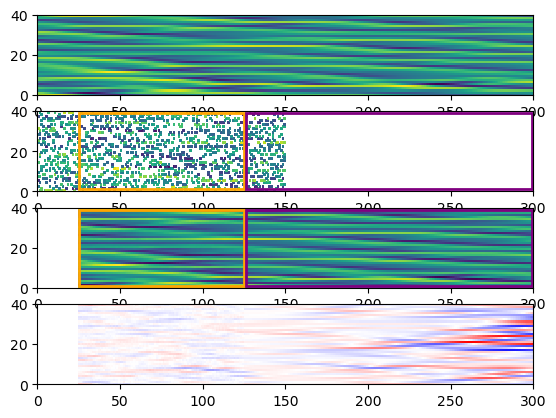

In [9]:
fig, axes = plt.subplots(4, 1)

img_gt = axes[0].pcolor(ground_truth.T)
img_obs = axes[1].pcolor(observations.T)
img_pred = axes[2].pcolor(analysis_and_forecast.T)

obs_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
obs_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[1].add_patch(obs_reconstraction_box)
axes[1].add_patch(obs_forecast_box)

pred_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
pred_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[2].add_patch(pred_reconstraction_box)
axes[2].add_patch(pred_forecast_box)


img_diff = axes[3].pcolor(difference.T, vmin=-vlim, vmax=vlim, cmap="bwr")



- Add estimated initial condition at t start timestep
- Add reconstruction window mean error +- std of error over 1000 experiments
- Add forecast reconstruction mean error +- std of error over 1000 experiments

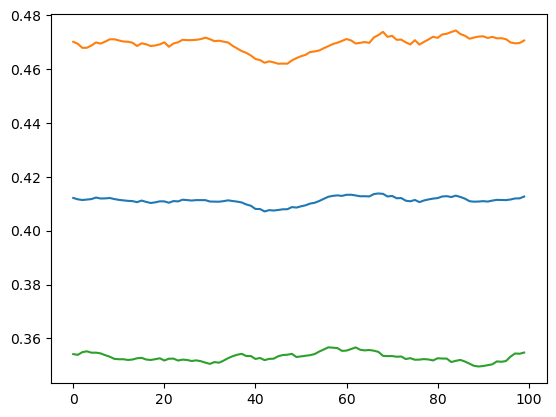

In [10]:
squered_errors = (reconstructions[:, :ri-li].cpu() - dataset.ground_truth[:, li:ri].cpu())**2
reconstruction_mean_errors = squered_errors.mean((-1, 0)).sqrt()
reconstruction_std_errors = squered_errors.mean((-1)).sqrt().std((0))

plt.plot(reconstruction_mean_errors)
plt.plot(reconstruction_mean_errors+reconstruction_std_errors)
plt.plot(reconstruction_mean_errors-reconstruction_std_errors)